<h1> Data Spaces' Tesina <h1>

<p>Imports section<p>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sn
from sklearn import neighbors, model_selection, metrics, preprocessing
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from matplotlib import pyplot as plt
from scipy import stats

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


<p> Read .csv file <p>

In [0]:
filename = "https://raw.githubusercontent.com/Vaelthur/DataSpaces_Tesina/master/dataR2.csv"

data = pd.read_csv(filename)
labels = data.columns

# Let's divide data into source and target (respectively X and Y)
X = data.iloc[:, 0:9]
Y = data.iloc[:, 9]

# records with the classification as "1" are Healthy Controls, "2" means Patients.

<p>Dataset Analysis - find and remove outliers</p>

Without outliers the dimension of my database is  80  instead of  116


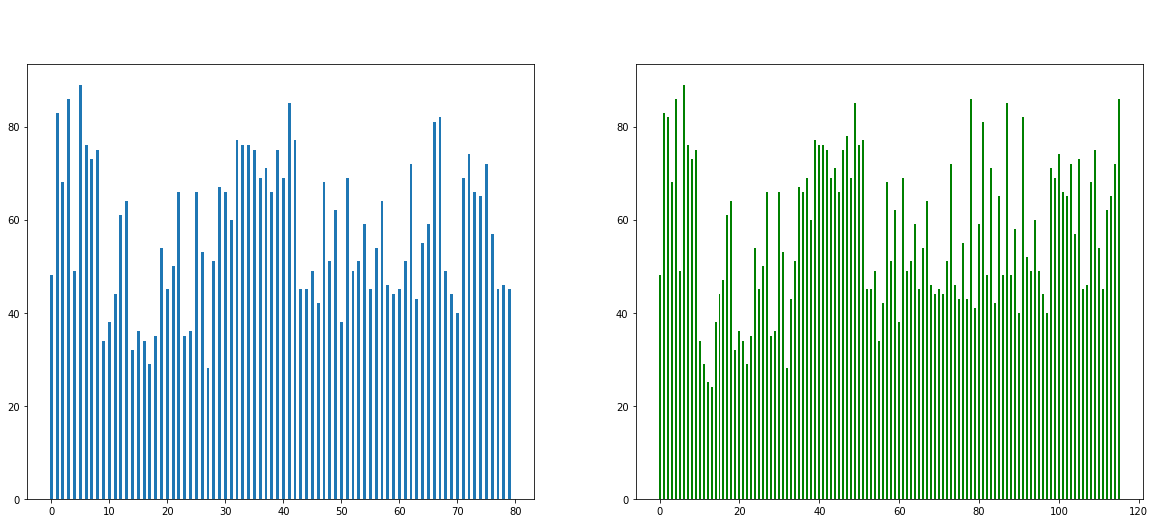

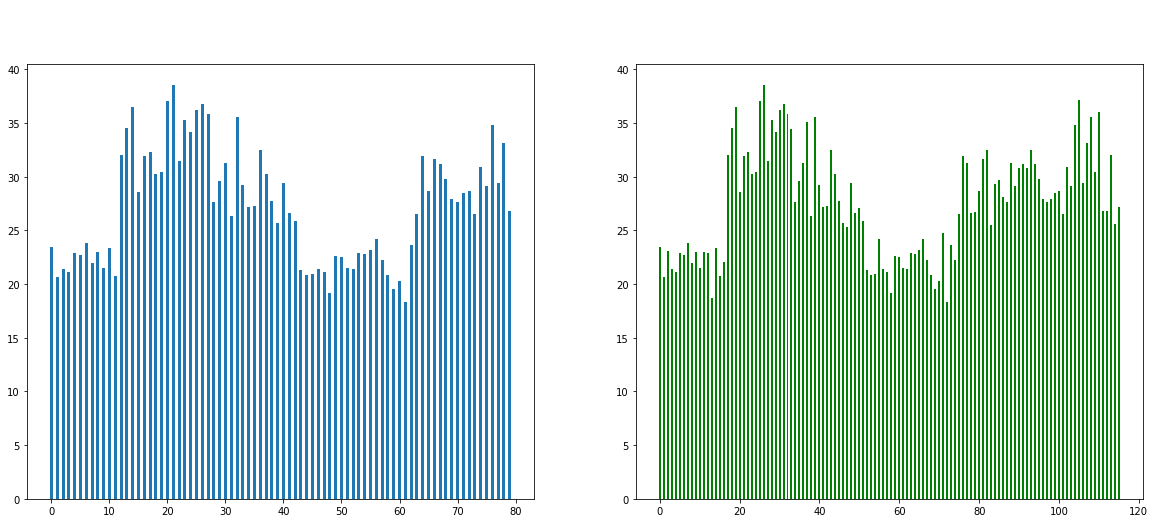

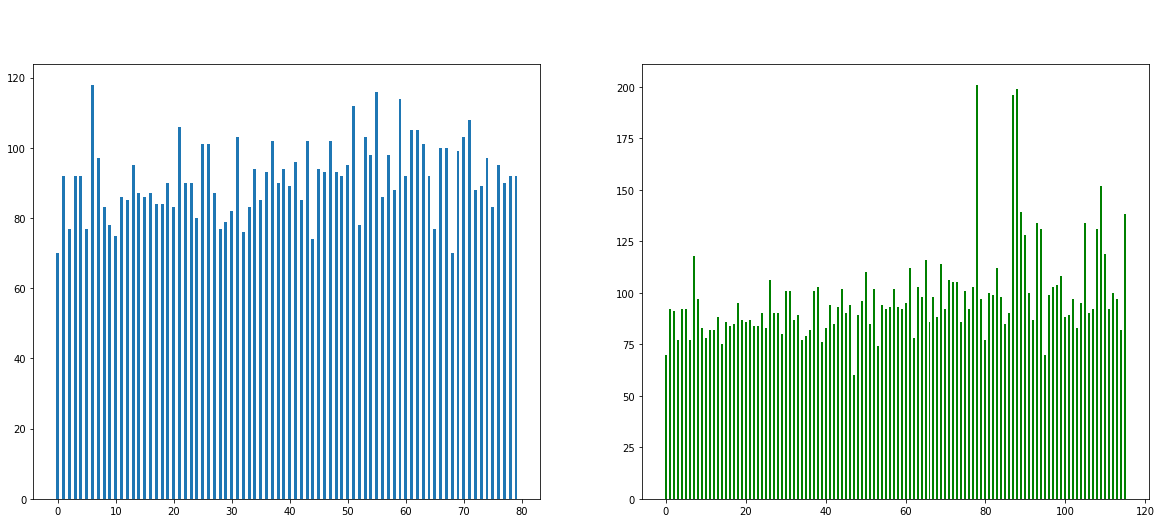

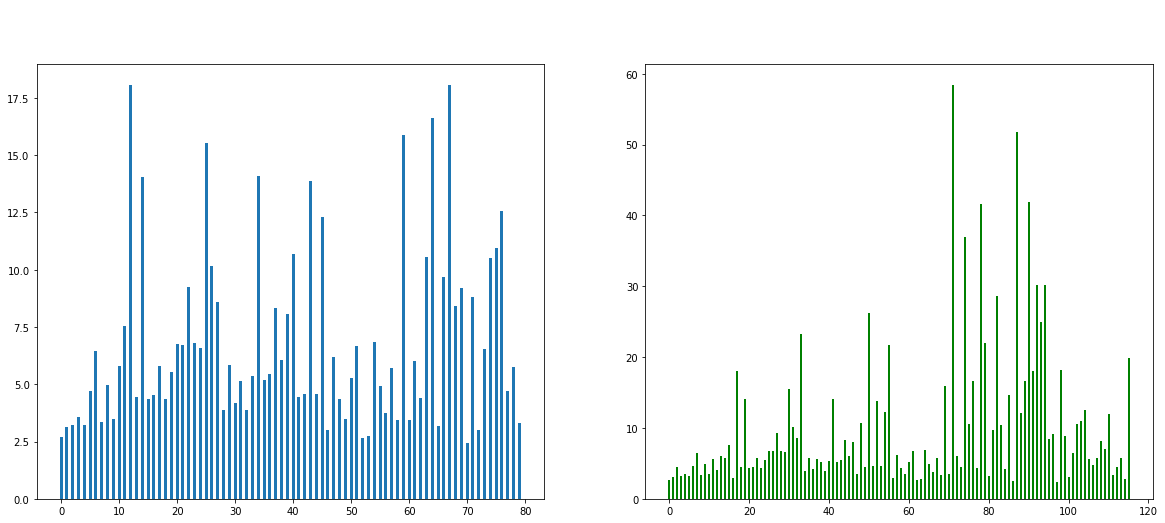

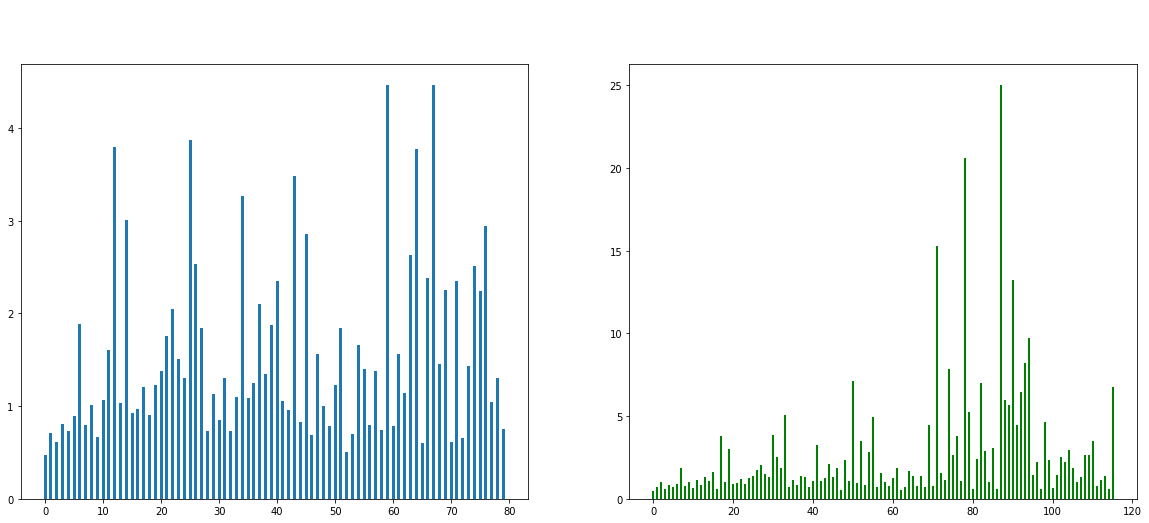

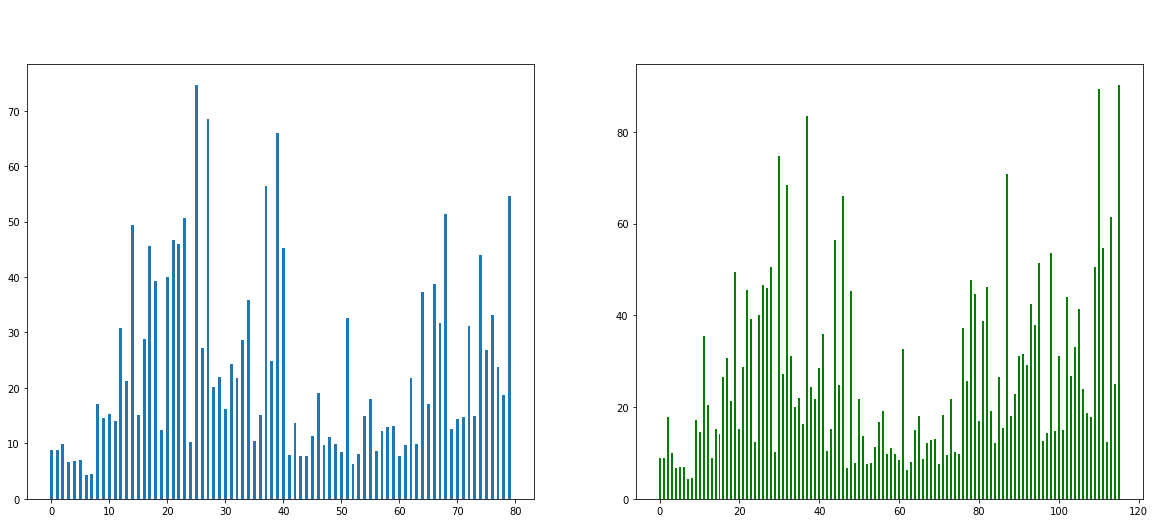

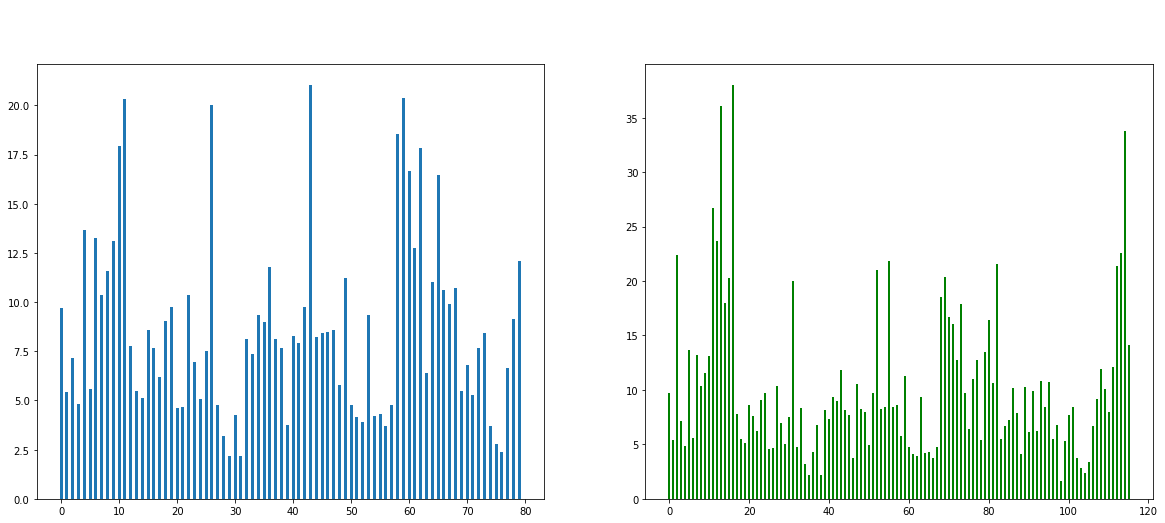

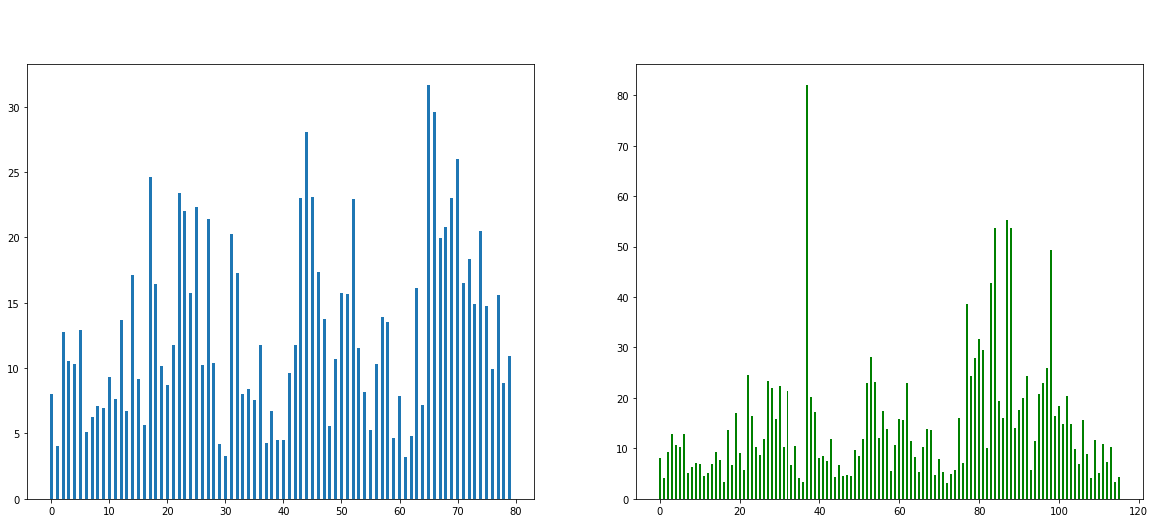

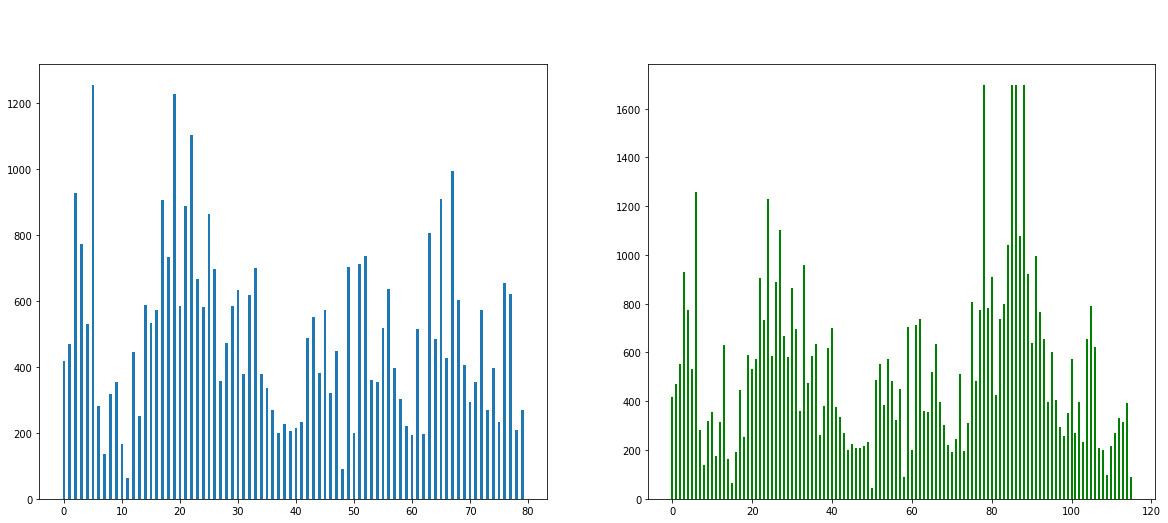

In [3]:
cleanDs = data

# remove outliers
for feature in X.columns:
  df = X[feature]
  sorted(df)
  q1, q3= np.percentile(df,[25,75])
  iqr = q3-q1
  lower_bound = q1 -(1.5 * iqr) 
  upper_bound = q3 +(1.5 * iqr)
  cleanDs = cleanDs[(cleanDs[feature]>lower_bound) & (cleanDs[feature]<upper_bound)]

for feature in cleanDs.iloc[:,0:9]:
  fig, (ax1, ax2) = plt.subplots(1,2)
  fig.set_size_inches(20,8)
  fig.suptitle(feature, color = 'white') 
  ax1.bar(np.arange(cleanDs.iloc[:,0:9].shape[0]), cleanDs.iloc[:,0:9][feature], 0.5)
  ax2.bar(np.arange(X.shape[0]), X[feature], 0.5, color='green')


print("Without outliers the dimension of my database is ", cleanDs.shape[0], " instead of ", X.shape[0])

<p> Check and balance Data </p>

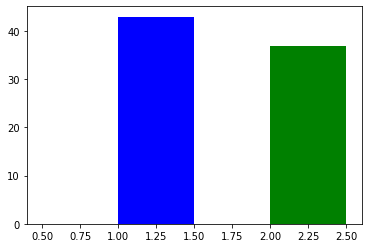

Percentage of 1 and 2 are:  53.75 % and  46.25 %


In [4]:
Y = cleanDs.iloc[:, 9]
ones = Y[Y == 1]
twos = Y[Y == 2]
plt.hist(ones, color='blue', width=0.5)
plt.hist(twos, color='green', width=0.5)
plt.show()
print("Percentage of 1 and 2 are: ", ones.shape[0]/Y.shape[0]*100, "% and ", twos.shape[0]/Y.shape[0]*100,"%")

<p>Observing the percentage of the two classes we can identify this dataset as balanced since the two classes don't go over the 60/40 ratio so it's acceptable.</p>

<p>Correlation Matrix to study correlation between data.</p>

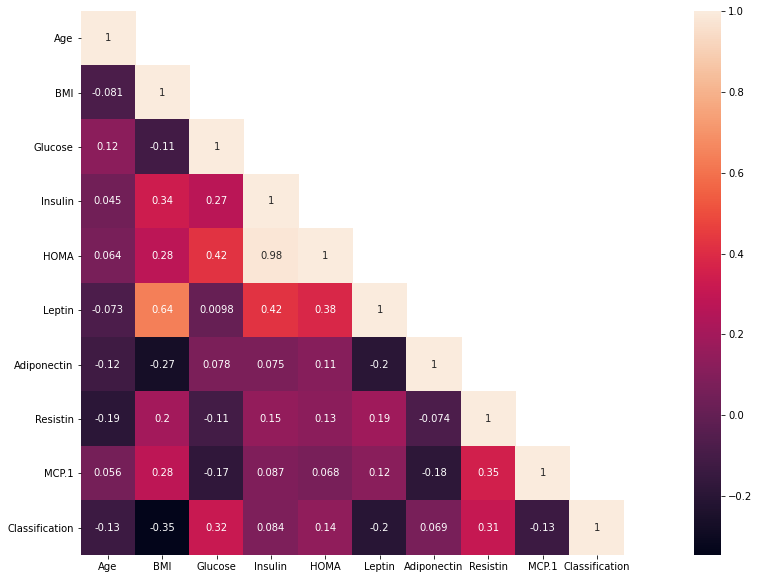

In [5]:
cm = cleanDs.corr() # Compute pairwise correlation of columns
mask = np.array(cm)
mask[np.tril_indices_from(mask)] = False
fig = plt.gcf()
fig.set_size_inches(25,10)
sn.heatmap(data=cm, mask=mask, square=True, annot=True, cbar=True)

We can observe that the correlation coefficient with any feaure aren't that good respect to the label. In this way we are going to select the ones with an higher absolute value and discard the others, this way we should have a 'cleaner' dataset with less feature and without significant loss of information. 

<p>Plot of feature against label </p>

In [0]:
cleanDs.drop('HOMA', axis=1, inplace=True)
# cleanDs.drop('BMI', axis=1, inplace=True)
# cleanDs.drop('Leptin', axis=1, inplace=True)
# cleanDs.drop('Adiponectin', axis=1, inplace=True)
# cleanDs.drop('MCP.1', axis=1, inplace=True)

<p><p>Preprocessing<p></p>

In [7]:
# normalize data because algorithms work better with normalized data - this one especially rescales it in a [0-1] range
scaler = preprocessing.MinMaxScaler()
cleanDs = scaler.fit_transform(cleanDs.drop('Classification', axis=1))

X_train, X_test, Y_train, Y_test = model_selection.train_test_split(cleanDs, Y, random_state=np.random.randint(0,100), test_size=0.25, shuffle=True)

print(X_train.shape)

(60, 8)


<p><u>K-NN</u></p>

In [8]:
# array of possible K to apply KNN neighbors
ks = [3,5,7,9]

for k in ks:
    n_neighbors = k
    
    # Create an instance of neighbors classifier (clf) and fit the data
    clf = neighbors.KNeighborsClassifier(n_neighbors)
    
    # train the classifier on the training set
    clf.fit(X_train, Y_train)
    
    print("Accuracy score on the test set with K =",n_neighbors,"is %.3f" %(clf.score(X_test, Y_test)))


    

Accuracy score on the test set with K = 3 is 0.750
Accuracy score on the test set with K = 5 is 0.850
Accuracy score on the test set with K = 7 is 0.750
Accuracy score on the test set with K = 9 is 0.650


<p><u>Logistic Regression</u><p>

In [9]:
logReg = LogisticRegression(solver="lbfgs", max_iter=2000) # instance of the model

logReg.fit(X_train, Y_train)

# res = logReg.predict(X_test)

print("Accuracy: ", logReg.score(X_test, Y_test))
print(classification_report(Y_test, logReg.predict(X_test)))

Accuracy:  0.7
              precision    recall  f1-score   support

           1       0.89      0.62      0.73        13
           2       0.55      0.86      0.67         7

    accuracy                           0.70        20
   macro avg       0.72      0.74      0.70        20
weighted avg       0.77      0.70      0.71        20



<p><u> Random forest</u> </p>

In [10]:
rndFor = RandomForestClassifier(n_estimators = 100, criterion="entropy")

rndFor.fit(X_train, Y_train)

y_pred = rndFor.predict(X_test)

print("Accuracy: ", metrics.accuracy_score(Y_test, y_pred))
print(classification_report(Y_test, rndFor.predict(X_test)))

Accuracy:  0.7
              precision    recall  f1-score   support

           1       0.89      0.62      0.73        13
           2       0.55      0.86      0.67         7

    accuracy                           0.70        20
   macro avg       0.72      0.74      0.70        20
weighted avg       0.77      0.70      0.71        20



<p><u> SVM</u> </p>

In [11]:
svc = SVC(gamma='auto', kernel='rbf')
svc.fit(X_train, Y_train)
print(classification_report(Y_test, svc.predict(X_test)),"\n")

              precision    recall  f1-score   support

           1       0.89      0.62      0.73        13
           2       0.55      0.86      0.67         7

    accuracy                           0.70        20
   macro avg       0.72      0.74      0.70        20
weighted avg       0.77      0.70      0.71        20
 



<p> So this is the accuracy with the default parameters, but with SVM approach is necessary to perform some parameters tuning in order to achieve a better result. To do so I relied on the GridSearch <p>
<p><u> SVM with GridSearch </u></p>

In [20]:
parameters = [{'C': [0.1, 0.2, 1, 10, 100, 1000], 'gamma': [0.0001, 0.001, 0.01, 0.1, 0.25, 1], 'kernel': ['rbf', 'poly', 'sigmoid']}]
svcGS = GridSearchCV(SVC(), parameters, n_jobs=-1, cv=10)
svcGS.fit(X_train, Y_train)

print(classification_report(Y_test, svcGS.predict(X_test)),"\n")

print("Confusion Matrix")
print(metrics.confusion_matrix(Y_test, svcGS.predict(X_test)))

              precision    recall  f1-score   support

           1       0.90      0.69      0.78        13
           2       0.60      0.86      0.71         7

    accuracy                           0.75        20
   macro avg       0.75      0.77      0.74        20
weighted avg       0.80      0.75      0.76        20
 

Confusion Matrix
[[9 4]
 [1 6]]


<p> The result above shows us a fuller report. </p>